In [10]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder


In [29]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/makine/Crop_recommendation.csv')

In [30]:
df = df[['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label']]

In [33]:
X = df.drop('label', axis=1)
y = df['label']

scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


In [34]:
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.values.reshape(-1, 1))

# Kolon isimleriyle birlikte DataFrame'e çevir
y_encoded_df = pd.DataFrame(y_encoded, columns=encoder.get_feature_names_out(['label']))


In [35]:
final_df = pd.concat([X_scaled, y_encoded_df], axis=1)

In [36]:
print(final_df)

             N         P      K  temperature  humidity        ph  rainfall  \
0     0.642857  0.264286  0.190     0.345886  0.790267  0.466264  0.656458   
1     0.607143  0.378571  0.180     0.371445  0.770633  0.549480  0.741675   
2     0.428571  0.357143  0.195     0.406854  0.793977  0.674219  0.875710   
3     0.528571  0.214286  0.175     0.506901  0.768751  0.540508  0.799905   
4     0.557143  0.264286  0.185     0.324378  0.785626  0.641291  0.871231   
...        ...       ...    ...          ...       ...       ...       ...   
2195  0.764286  0.207143  0.135     0.515037  0.608410  0.509353  0.566064   
2196  0.707143  0.071429  0.110     0.533473  0.494359  0.401561  0.386972   
2197  0.842857  0.200000  0.125     0.439202  0.617880  0.444433  0.550071   
2198  0.835714  0.192857  0.145     0.500627  0.441760  0.506045  0.384280   
2199  0.742857  0.092857  0.125     0.424029  0.538222  0.509317  0.433721   

      label_apple  label_banana  label_blackgram  ...  label_ma

**ÖZELLİK SEÇİMİ**

In [37]:
# variance threshold
from sklearn.feature_selection import VarianceThreshold

# Özellikleri ayır
X = final_df.drop(columns=[col for col in final_df.columns if col.startswith("label_")])

# Variance Threshold uygulayalım (0.01 eşik değeriyle)
selector = VarianceThreshold(threshold=0.01)
X_var = selector.fit_transform(X)

# Seçilen sütun isimlerini al
selected_features_var = X.columns[selector.get_support()]
print("Variance Threshold ile seçilen özellikler:\n", selected_features_var)


Variance Threshold ile seçilen özellikler:
 Index(['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall'], dtype='object')


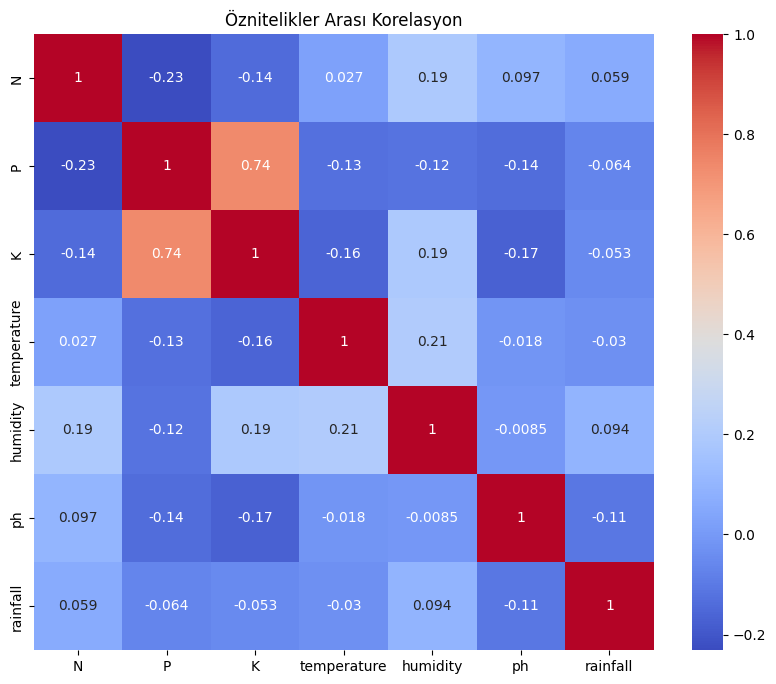

In [38]:
#heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Korelasyon matrisi çiz
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, cmap="coolwarm")
plt.title("Öznitelikler Arası Korelasyon")
plt.show()


In [39]:
#chi square
from sklearn.feature_selection import SelectKBest, chi2
import numpy as np
import pandas as pd

# Hedef sütunları al (one-hot)
y = final_df[[col for col in final_df.columns if col.startswith("label_")]]

# Her bir sınıf için chi2 skorlarını hesapla ve ortalamalarını al
chi_scores = []
for i in range(y.shape[1]):
    chi_selector = SelectKBest(score_func=chi2, k='all')
    chi_selector.fit(X, y.iloc[:, i])
    chi_scores.append(chi_selector.scores_)

# Ortalama skorları hesapla
avg_scores = np.mean(chi_scores, axis=0)

# DataFrame'e çevirip sıralayalım
chi_df = pd.DataFrame({'feature': X.columns, 'avg_chi2_score': avg_scores})
chi_df = chi_df.sort_values(by='avg_chi2_score', ascending=False)
print(chi_df)


       feature  avg_chi2_score
2            K       31.008246
0            N       18.076428
1            P       15.950349
6     rainfall       11.652722
4     humidity       10.238866
3  temperature        2.277303
5           ph        1.210139


In [41]:
from sklearn.model_selection import train_test_split

# Özellikler ve hedefi ayır
X = final_df.drop(columns=[col for col in final_df.columns if col.startswith("label_")])
y = final_df[[col for col in final_df.columns if col.startswith("label_")]]

# %80 eğitim, %20 test olacak şekilde ayır
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


**KNN**

In [85]:
from sklearn.neighbors import KNeighborsClassifier

# One-hot etiketleri argmax ile sınıfa çevir
y_train_labels = np.argmax(y_train.values, axis=1)
y_test_labels = np.argmax(y_test.values, axis=1)

# KNN modeli oluştur ve eğit
knn = KNeighborsClassifier(n_neighbors=5)  # k=5, istersen değiştirilebilir
knn.fit(X_train, y_train_labels)


KNeighborsClassifier()

In [87]:
from sklearn.metrics import accuracy_score

# Test verisi üzerinde tahmin yap
y_pred_knn = knn.predict(X_test)

# Doğruluk
print("Accuracy:", accuracy_score(y_test_labels, y_pred_knn))
print("\nClassification Report:\n", classification_report(y_test_labels, y_pred_knn))

Accuracy: 0.9818181818181818

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           2       0.95      1.00      0.98        20
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00        20
           6       0.95      1.00      0.98        20
           7       1.00      1.00      1.00        20
           8       0.86      0.90      0.88        20
           9       1.00      1.00      1.00        20
          10       1.00      1.00      1.00        20
          11       1.00      0.95      0.97        20
          12       1.00      1.00      1.00        20
          13       1.00      0.95      0.97        20
          14       1.00      1.00      1.00        20
          15       1.00      1.00      1.00        20
          16       1.00    

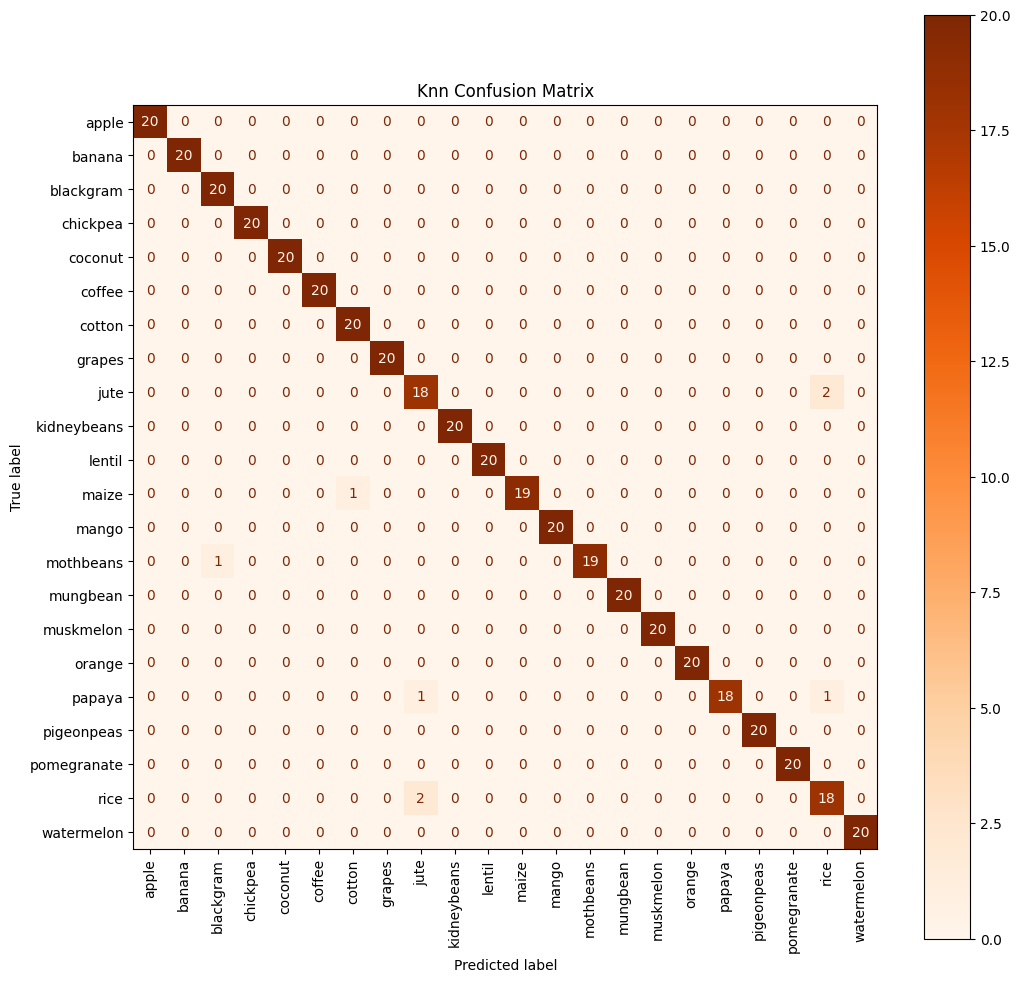

In [89]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred_knn)
labels = [col.replace("label_", "") for col in y_train.columns]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, xticks_rotation=90, cmap="Oranges")
plt.title("Knn Confusion Matrix")
plt.show()

**NAİVE BAYES**

In [79]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# One-hot etiketleri argmax ile sınıfa çevir
y_train_labels = np.argmax(y_train.values, axis=1)
y_test_labels = np.argmax(y_test.values, axis=1)

# Modeli eğit
gnb = GaussianNB()
gnb.fit(X_train, y_train_labels)

# Tahmin
y_pred_nb = gnb.predict(X_test)

# Doğruluk
print("Accuracy:", accuracy_score(y_test_labels, y_pred_nb))
print("\nClassification Report:\n", classification_report(y_test_labels, y_pred_nb))

Accuracy: 0.9954545454545455

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00        20
           6       0.95      1.00      0.98        20
           7       1.00      1.00      1.00        20
           8       0.95      1.00      0.98        20
           9       1.00      1.00      1.00        20
          10       1.00      1.00      1.00        20
          11       1.00      0.95      0.97        20
          12       1.00      1.00      1.00        20
          13       1.00      1.00      1.00        20
          14       1.00      1.00      1.00        20
          15       1.00      1.00      1.00        20
          16       1.00    

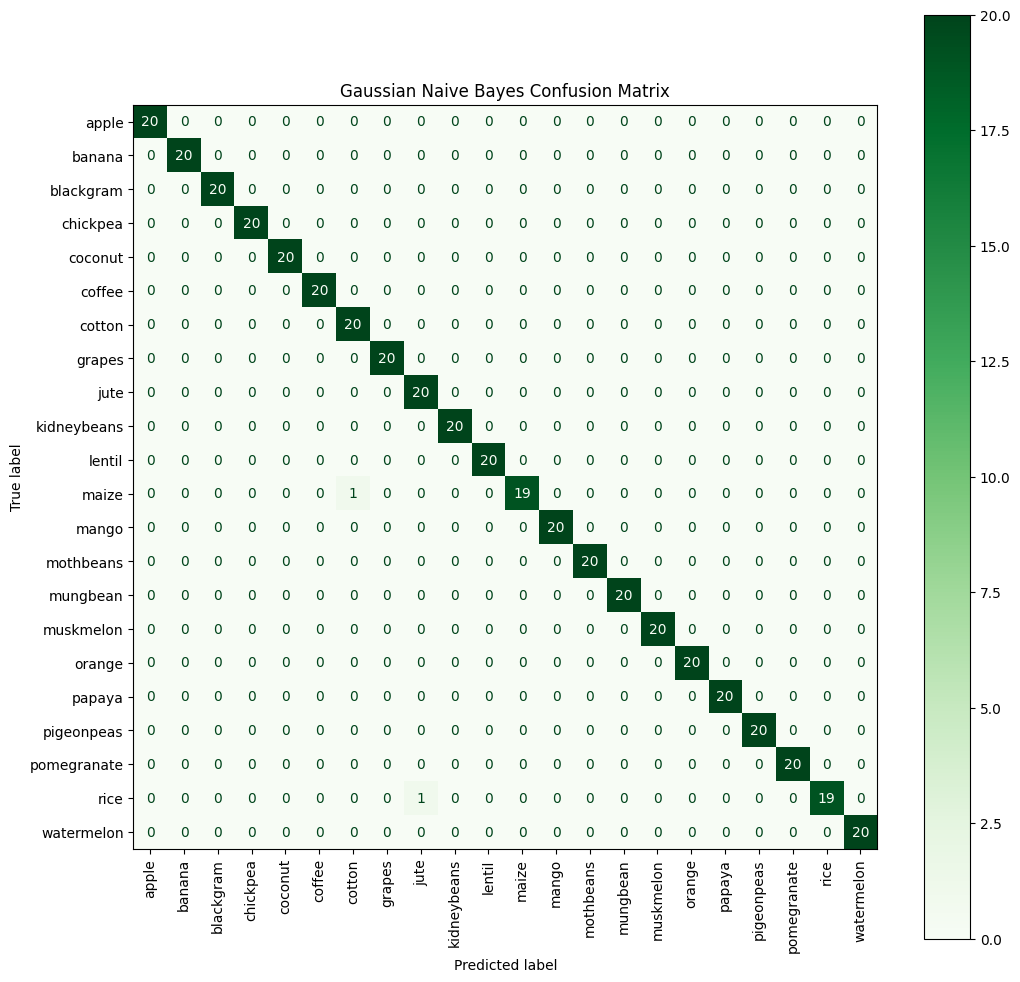

In [78]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred_nb)
labels = [col.replace("label_", "") for col in y_train.columns]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, xticks_rotation=90, cmap="Greens")
plt.title("Gaussian Naive Bayes Confusion Matrix")
plt.show()

**LOJİSTİK REGRESYON**

In [72]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# One-hot -> sınıf index
y_train_labels = np.argmax(y_train.values, axis=1)
y_test_labels = np.argmax(y_test.values, axis=1)


In [73]:
# Çok sınıflı lojistik regresyon (softmax ile)
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
clf.fit(X_train, y_train_labels)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial')

In [80]:
# Test seti tahmini
y_pred_lr = clf.predict(X_test)

# Başarı skorları
print("Accuracy:", accuracy_score(y_test_labels, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test_labels, y_pred_lr))

Accuracy: 0.9477272727272728

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           2       0.86      0.90      0.88        20
           3       1.00      1.00      1.00        20
           4       0.95      1.00      0.98        20
           5       0.95      1.00      0.98        20
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00        20
           8       1.00      0.50      0.67        20
           9       1.00      1.00      1.00        20
          10       0.90      0.90      0.90        20
          11       1.00      1.00      1.00        20
          12       0.95      1.00      0.98        20
          13       0.94      0.85      0.89        20
          14       0.95      1.00      0.98        20
          15       1.00      1.00      1.00        20
          16       1.00    

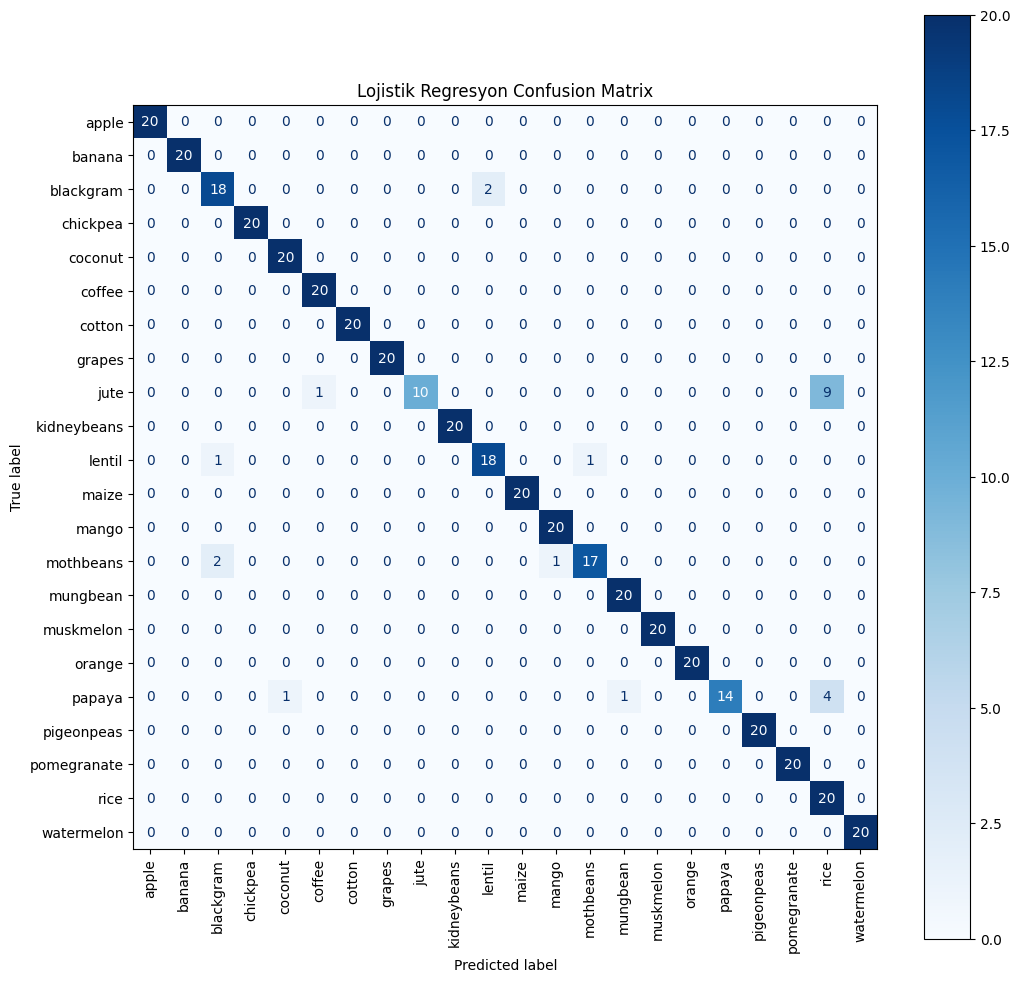

In [75]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_labels, y_pred_lr)
labels = [col.replace("label_", "") for col in y_train.columns]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues")
plt.title("Lojistik Regresyon Confusion Matrix")
plt.show()


**SVC**

In [71]:
from sklearn.svm import SVC

svc = SVC(kernel='rbf', decision_function_shape='ovr')
svc.fit(X_train, y_train_labels)
y_pred_svc = svc.predict(X_test)

print("SVC Accuracy:", accuracy_score(y_test_labels, y_pred_svc))
print("\nClassification Report:\n", classification_report(y_test_labels, y_pred_svc))

SVC Accuracy: 0.990909090909091

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00        20
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00        20
           8       0.90      0.90      0.90        20
           9       1.00      1.00      1.00        20
          10       1.00      1.00      1.00        20
          11       1.00      1.00      1.00        20
          12       1.00      1.00      1.00        20
          13       1.00      1.00      1.00        20
          14       1.00      1.00      1.00        20
          15       1.00      1.00      1.00        20
          16       1.00 

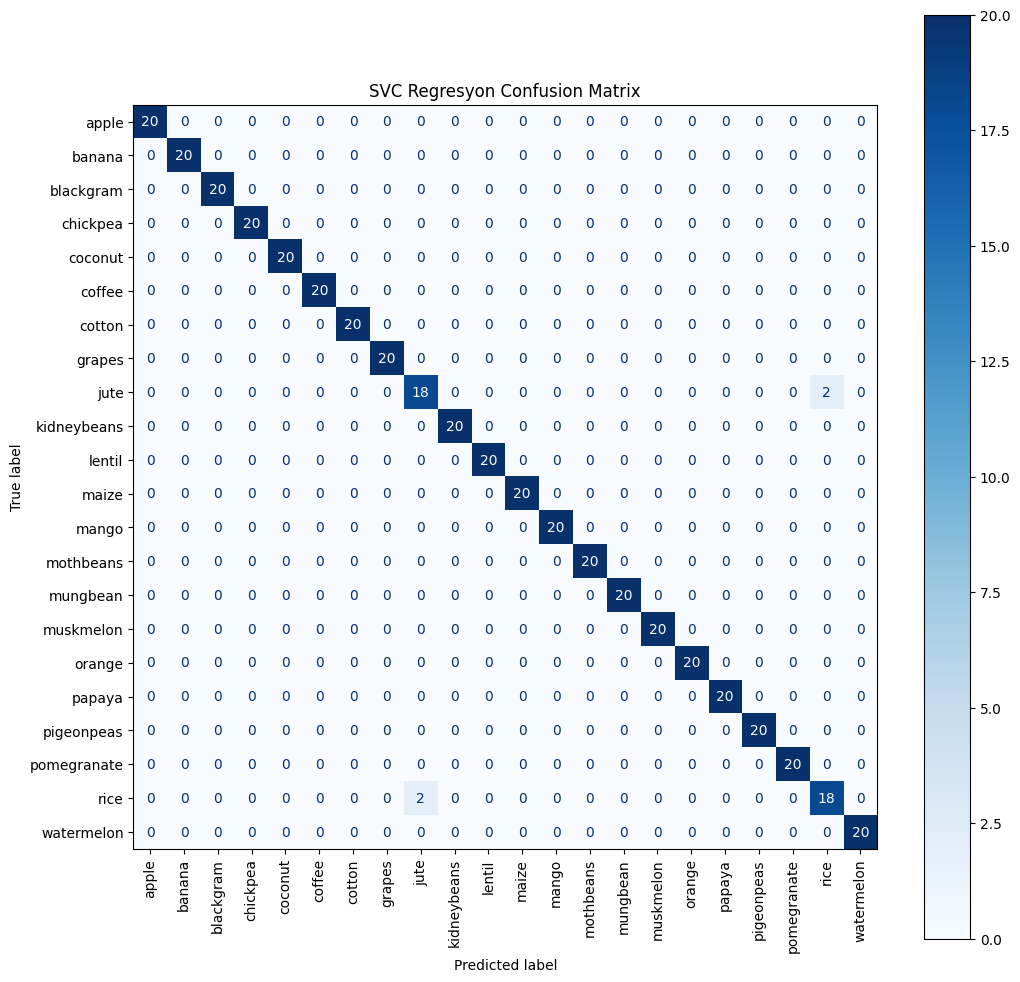

In [66]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_labels, y_pred_svc)
labels = [col.replace("label_", "") for col in y_train.columns]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues")
plt.title("SVC Regresyon Confusion Matrix")
plt.show()

**Random Forest**

In [67]:
from sklearn.ensemble import RandomForestClassifier

# Modeli oluştur ve eğit
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train_labels)


RandomForestClassifier(random_state=42)

In [68]:
# Tahmin
y_pred_rf = rf.predict(X_test)


In [69]:
from sklearn.metrics import accuracy_score, classification_report

# Skorlar
print("Random Forest Accuracy:", accuracy_score(y_test_labels, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test_labels, y_pred_rf))


Random Forest Accuracy: 0.9977272727272727

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           2       1.00      0.95      0.97        20
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00        20
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00        20
           8       1.00      1.00      1.00        20
           9       1.00      1.00      1.00        20
          10       1.00      1.00      1.00        20
          11       0.95      1.00      0.98        20
          12       1.00      1.00      1.00        20
          13       1.00      1.00      1.00        20
          14       1.00      1.00      1.00        20
          15       1.00      1.00      1.00        20
          16 

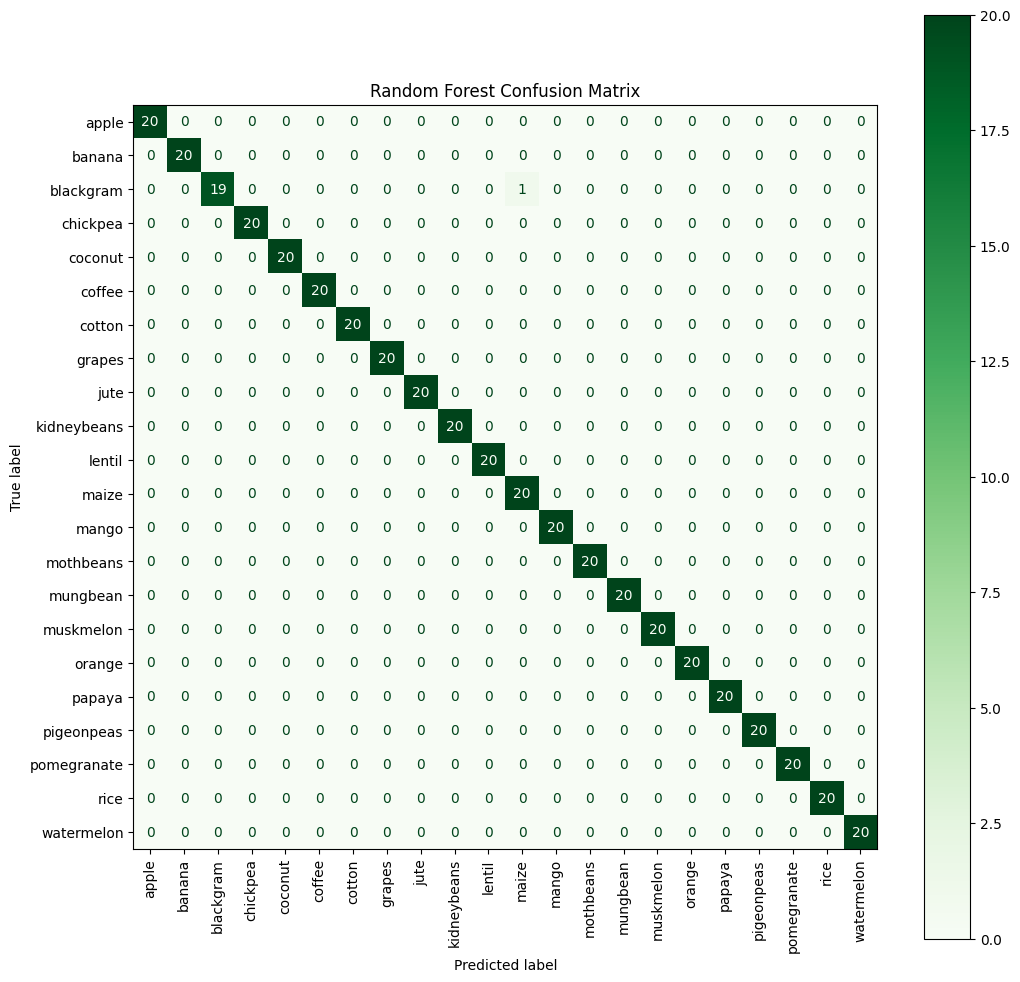

In [70]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred_rf)
labels = [col.replace("label_", "") for col in y_train.columns]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, xticks_rotation=90, cmap="Greens")
plt.title("Random Forest Confusion Matrix")
plt.show()
